In [19]:
from scipy.cluster.vq import vq
import numpy as np
import glob
from skimage.feature import SIFT
import cv2
from PIL.Image import Image
from matplotlib import pyplot as plt

queen_path = glob.glob("Queen-Resized/*.jpg", recursive=True)
bishop_path = glob.glob("bishop_resized/*.jpg", recursive=True)
knight_path = glob.glob("knight-resize/*.jpg", recursive=True)
pawn_path = glob.glob("pawn_resized/*.jpg", recursive=True)
rook_path = glob.glob("Rook-resize/*.jpg", recursive=True)

image_paths = bishop_path + knight_path + pawn_path + queen_path + rook_path

images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths]

sift = SIFT()
descriptors = []

images_valid = []
descriptors = []

for img in images:
    try:
        sift.detect_and_extract(img)
        if sift.descriptors is not None and len(sift.descriptors) > 0:
            descriptors.append(sift.descriptors)
            images_valid.append(img)  # μόνο τις χρήσιμες
    except RuntimeError:
        print("SIFT failed on one image. Skipping.")

images_gray = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in image_paths]

image_paths_valid = []
for img, path in zip(images_gray, image_paths):
    for valid_img in images_valid:
        if np.array_equal(img, valid_img):
            image_paths_valid.append(path)
            break

all_descriptors = np.vstack([desc for desc in descriptors if desc is not None]).astype(float)

# -------------------- 4. Εκπαίδευση KMeans (λεξικό) --------------------
k = 100  # Αριθμός visual words
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
attempts = 10
flags = cv2.KMEANS_RANDOM_CENTERS

all_descriptors = all_descriptors.astype(np.float32)

compactness, labels, centers = cv2.kmeans(all_descriptors, k, None, criteria, attempts, flags)
codebook = centers

# -------------------- 5. Αντιστοίχιση descriptors σε visual words --------------------
visual_words = []
for desc in descriptors:
    if desc is not None:
        words, _ = vq(desc, codebook)
    else:
        words = np.array([])
    visual_words.append(words)

# -------------------- 6. Δημιουργία BoVW vector (ιστόγραμμα) --------------------
bovw_vectors = []
for words in visual_words:
    hist = np.zeros(k)
    for w in words:
        hist[w] += 1
    bovw_vectors.append(hist)

bovw_vectors = np.stack(bovw_vectors)

# -------------------- 7. (Προαιρετικά) TF-IDF μετασχηματισμός --------------------
N = len(bovw_vectors)
df = np.sum(bovw_vectors > 0, axis=0)
idf = np.log(N / (df + 1e-6))  # μικρή τιμή για αποφυγή log(0)
tf_idf = bovw_vectors * idf

# -------------------- 8. Προβολή αποτελεσμάτων --------------------


SIFT failed on one image. Skipping.
SIFT failed on one image. Skipping.
SIFT failed on one image. Skipping.
SIFT failed on one image. Skipping.
SIFT failed on one image. Skipping.
SIFT failed on one image. Skipping.


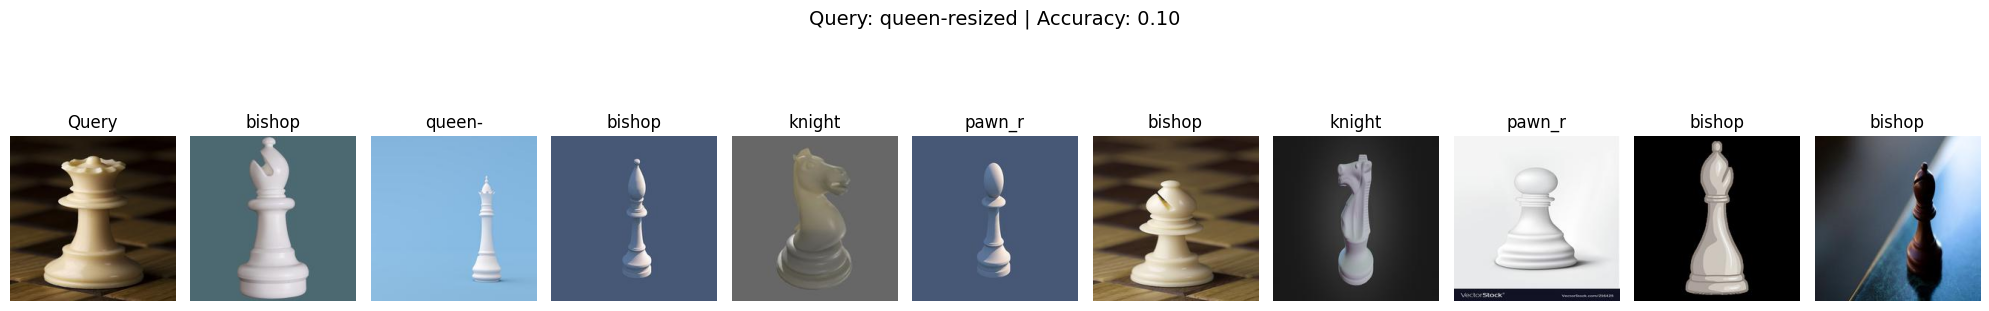

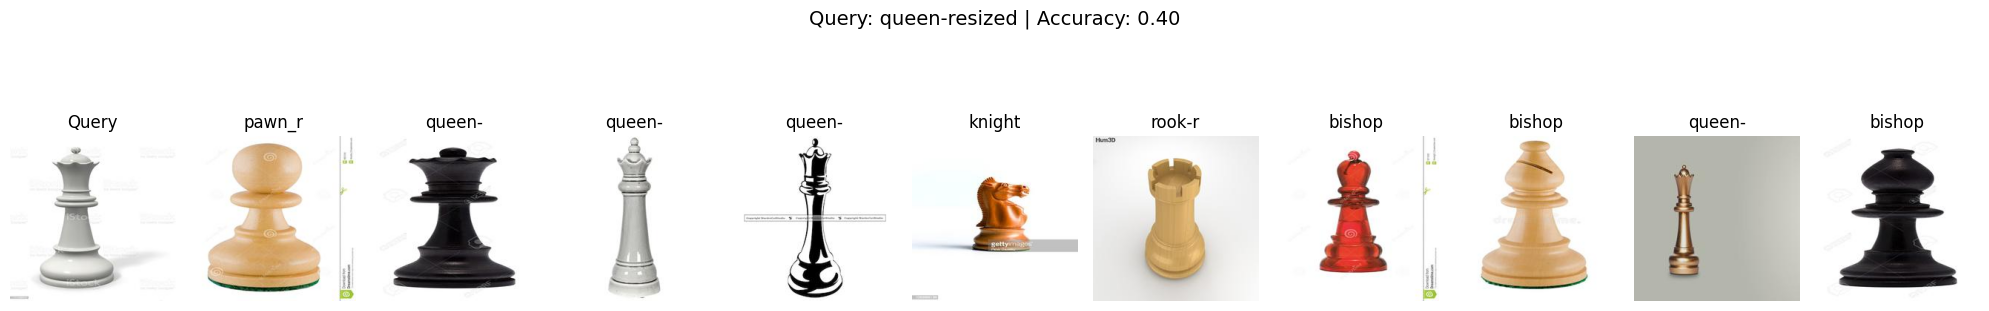

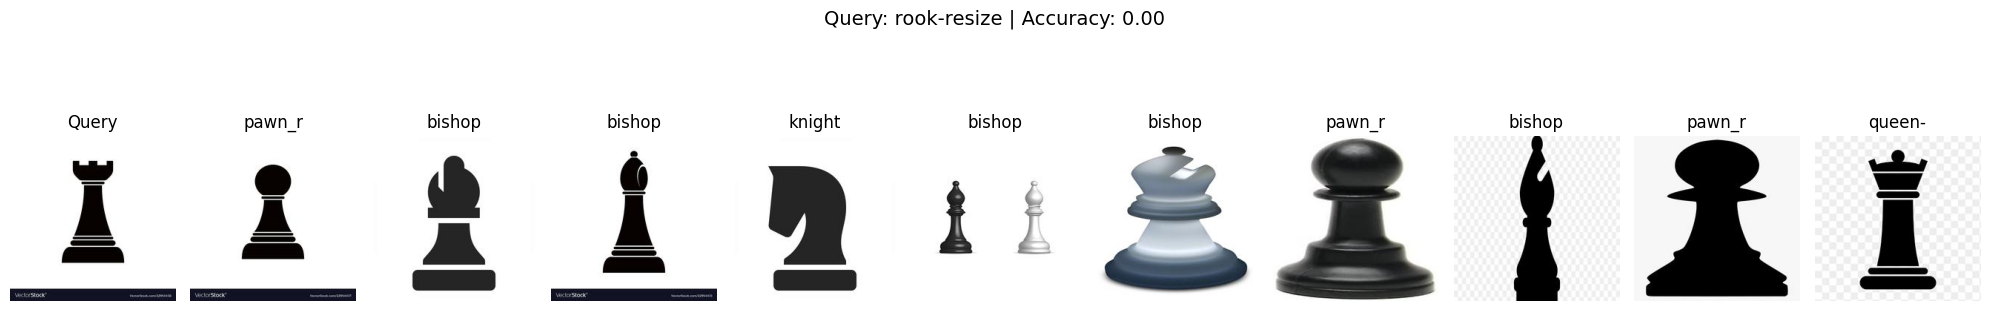

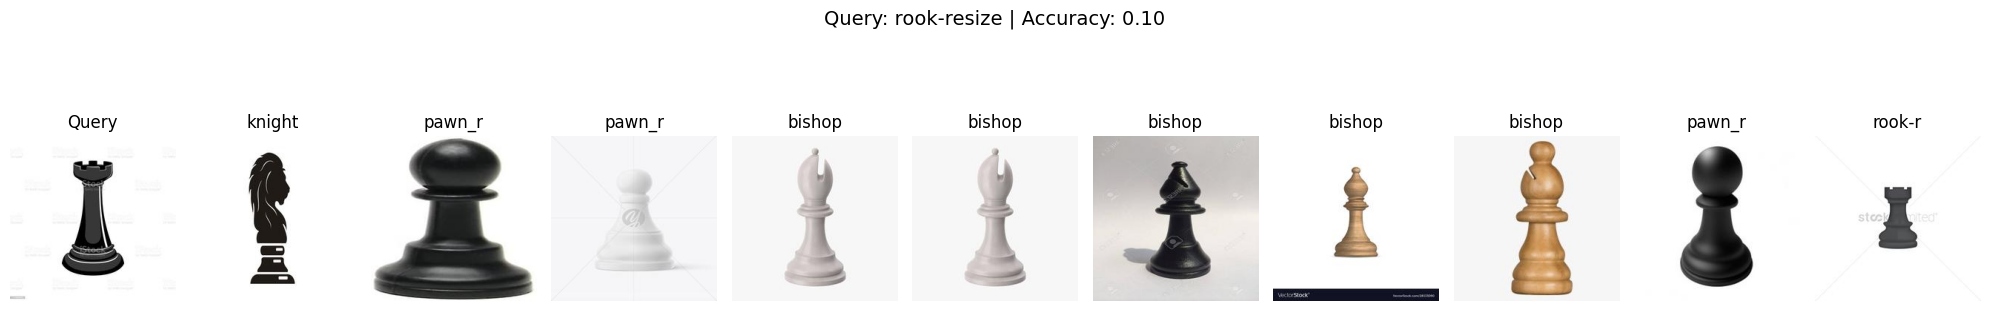

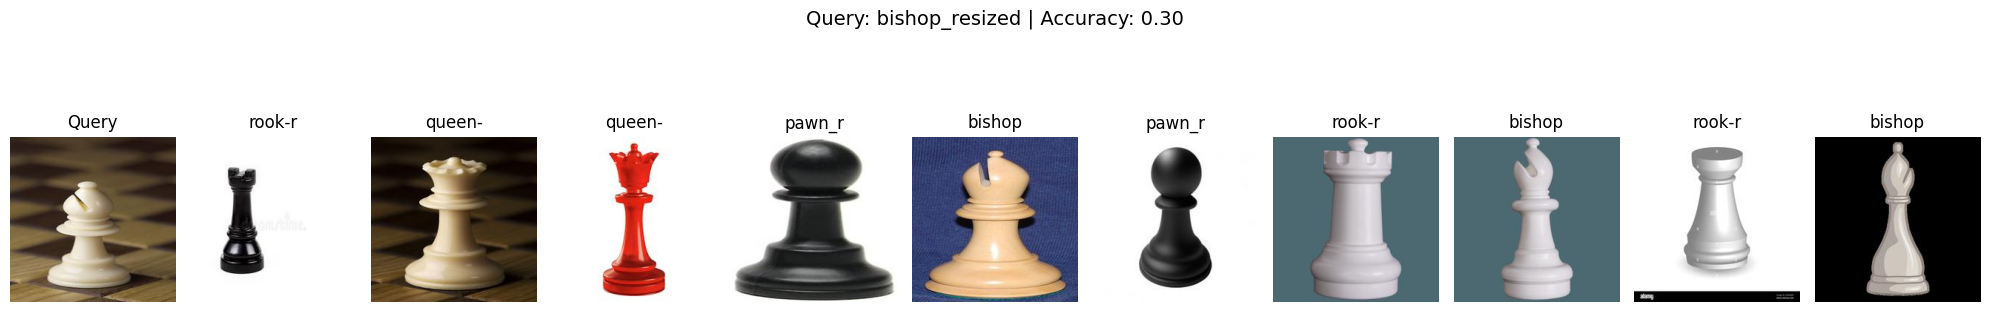

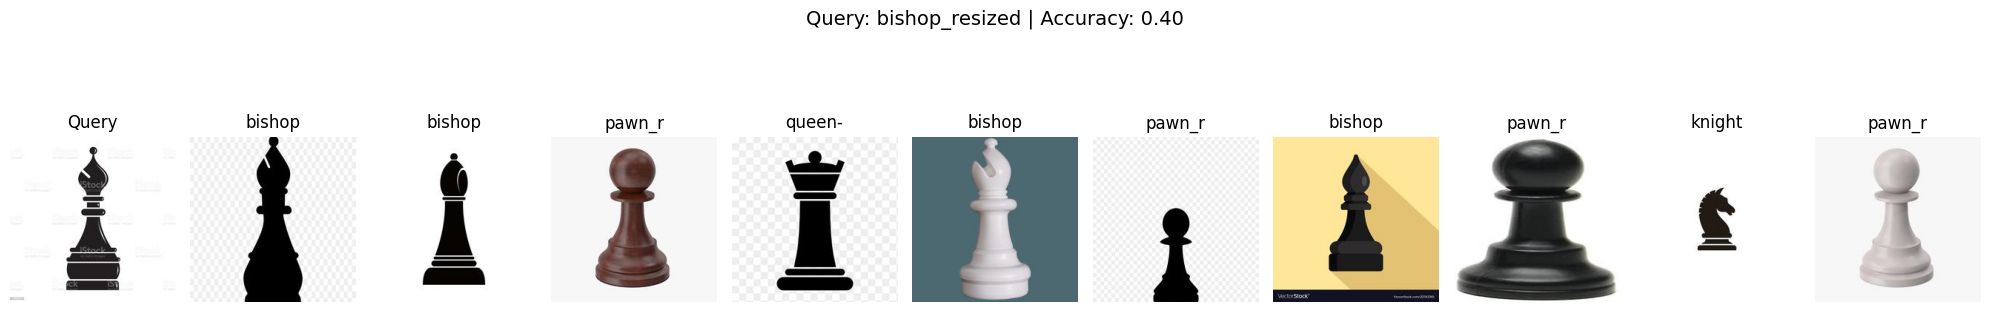

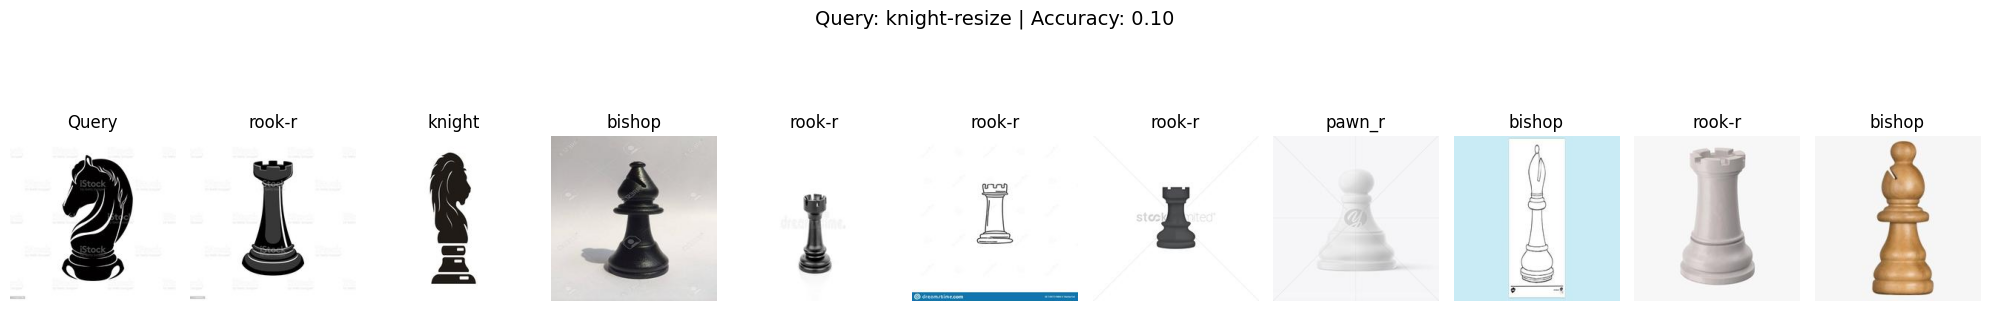

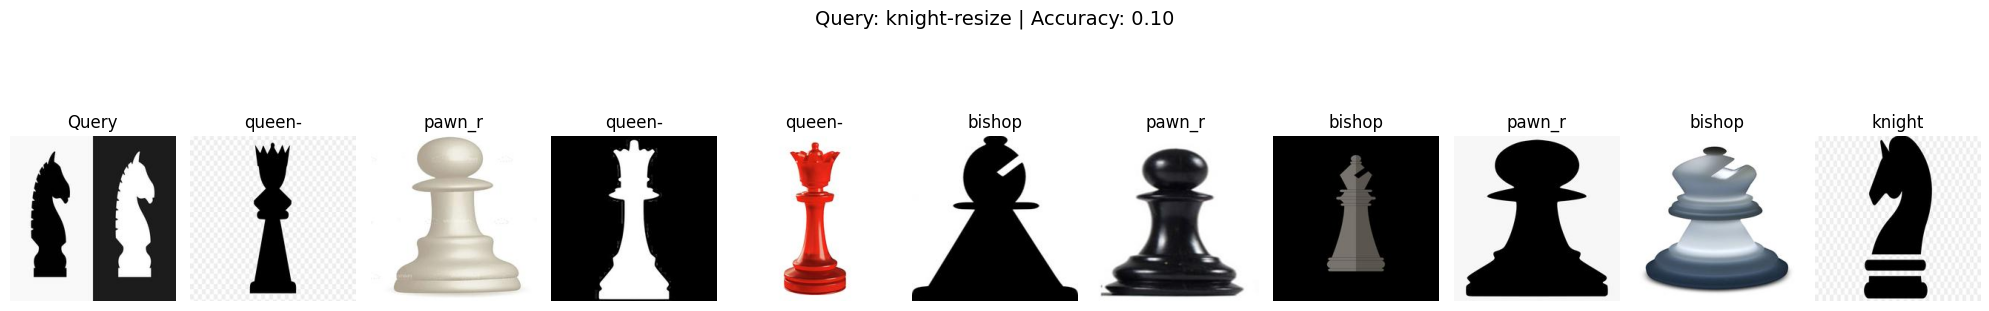

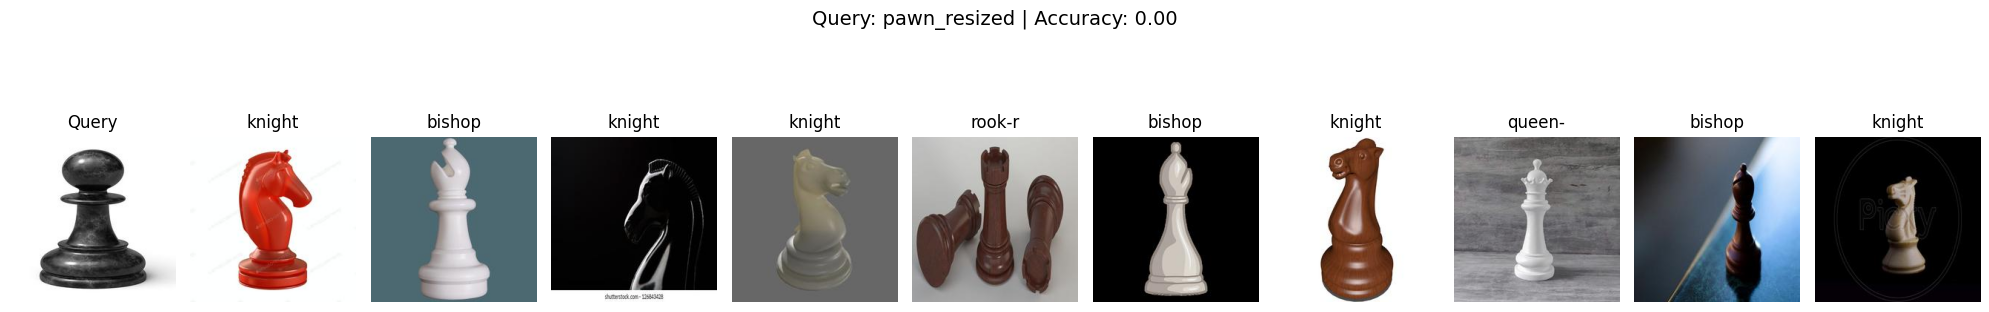

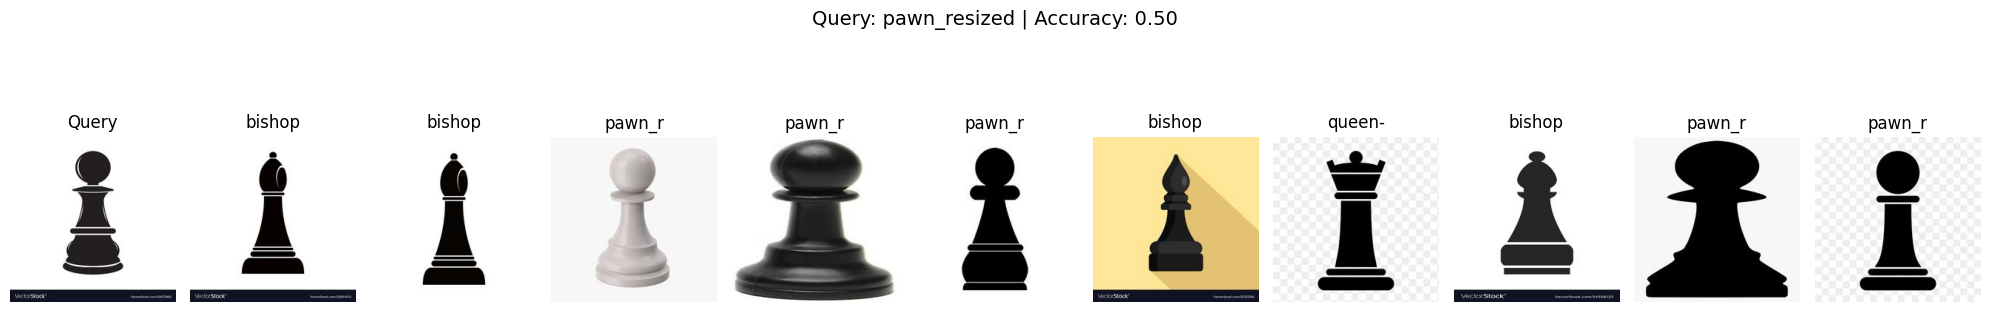


📊 Μέση Ακρίβεια Ανάκτησης (Top-10): 0.20


In [24]:
from matplotlib import image as mpimg
from sklearn.metrics import pairwise_distances
# B

from scipy.spatial.distance import cdist
import os

query_filenames = [
    "Queen-Resized/00000000_resized.jpg",
    "Queen-Resized/00000001_resized.jpg",
    "Rook-resize/00000001_resized.jpg",
    "Rook-resize/00000002_resized.jpg",
    "bishop_resized/00000000_resized.jpg",
    "bishop_resized/00000002_resized.jpg",
    "knight-resize/00000001_resized.jpg",
    "knight-resize/00000002_resized.jpg",
    "pawn_resized/00000001_resized.jpg",
    "pawn_resized/00000002_resized.jpg"
]


# Αντιστοίχιση path -> index
image_path_map = {os.path.normpath(p): i for i, p in enumerate(image_paths_valid)}

# Λίστα με index των query εικόνων
query_indices = []
for q in query_filenames:
    q_norm = os.path.normpath(q)
    if q_norm in image_path_map:
        query_indices.append(image_path_map[q_norm])
    else:
        print(f"⚠️ Δεν βρέθηκε: {q}")


features = tf_idf  # μπορείς και bovw_vectors αν δεν θέλεις TF-IDF
dist_matrix = cdist(features, features, metric='euclidean')

accuracies = []

for query_idx in query_indices:
    dists = dist_matrix[query_idx]
    dists[query_idx] = np.inf

    top_indices = np.argsort(dists)[:10]
    query_path = image_paths_valid[query_idx]
    query_label = os.path.normpath(query_path).split(os.sep)[0].lower()
    retrieved_paths = [image_paths_valid[i] for i in top_indices]
    retrieved_labels = [os.path.normpath(p).split(os.sep)[0].lower() for p in retrieved_paths]

    correct = sum(1 for lbl in retrieved_labels if lbl == query_label)
    accuracy = correct / 10.0
    accuracies.append(accuracy)

    # Εμφάνιση με εικόνες
    fig, axs = plt.subplots(1, 11, figsize=(20, 4))
    fig.suptitle(f"Query: {query_label} | Accuracy: {accuracy:.2f}", fontsize=14)

    # Query image
    axs[0].imshow(mpimg.imread(query_path), cmap='gray')
    axs[0].set_title("Query")
    axs[0].axis("off")

    # Top-10
    for j, (img_path, lbl) in enumerate(zip(retrieved_paths, retrieved_labels), start=1):
        axs[j].imshow(mpimg.imread(img_path), cmap='gray')
        axs[j].set_title(lbl[:6])  # π.χ. "queen", "pawn", ...
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()


# Μέση ακρίβεια
mean_accuracy = np.mean(accuracies)
print(f"\n📊 Μέση Ακρίβεια Ανάκτησης (Top-10): {mean_accuracy:.2f}")